# Rule Based Relation-Extraction

In [1]:
import os
import pandas as pd
import re
import spacy 
from spacy import displacy

# Load the en_core_web_sm model
nlp = spacy.load("en_core_web_lg")

```
# https://stackoverflow.com/a/47784683
from dataclasses import dataclass

@dataclass(eq=True)
class Relation:
    subj: str
    rel: str
    obj: str
    type: str
Relation('ben','is','here','DIRECT')
```

## Dataset

In [2]:
texts =  [
    # https://www.bbc.co.uk/news/world-us-canada-60177979
    (
        "The US East Coast is hunkering down as a major blizzard hits the region for the first time in four years."
        "The storm is forecast to stretch from the Carolinas to Maine, packing hurricane-force winds in coastal parts."
        "Five states have declared emergencies."
        "Mayor Michelle Wu of Boston, a city that is no stranger to snowfall, said the storm could be 'historic'."
        "More than two feet of snow could fall in New England."
        "Weather officials also warn of flooding near the coast."
        "Over 5,000 US flights were cancelled between Friday and Sunday, according to FlightAware."
        "Forecasters say there is a chance the storm, known as a Nor\'easter, will blanket the Boston area with up to 2ft (61cm) of snow."
        ),
    # https://www.bbc.co.uk/news/business-60163814
    (  
        "Apple sales soared in the key Christmas shopping season, despite constraints due to a global shortage of microchips."
        "Sales at the iPhone giant rose 11% to a record $123.9bn (£92.6bn) in the October to December period, beating forecasts."
        "Shares jumped more than 4% in after-hours trade, as the report suggested the firm's pandemic boom is continuing."
        "Apple has seen purchases skyrocket during the pandemic as people spend more time online."
        "The firm's market value briefly hit the $3tn milestone in early January though its share price has slipped more recently amid weeks of market turmoil."
        ),
    # https://news.sky.com/story/staycation-frenzy-spurs-center-parcs-owner-to-prepare-4bn-sale-12527982
    (
        "Sky News has learnt that Brookfield Property Partners, the Canadian property giant, is paving the way to sell Center Parcs UK potentially as soon as this year."
        "City sources said this weekend that Brookfield had engaged the accountancy firm PriceWaterhouseCoopers to assist with preparations for a sale process."
        "Investment banks have yet to be formally appointed to handle an auction, and one person close to the process said it was possible that Brookfield would decide to retain the business for a longer period if it did not secure a sufficiently attractive offer."
        "Center Parcs is one of the most famous brands in the British leisure industry, drawing millions of visitors annually to its five UK sites and the latest addition to its portfolio, at Longford Forest in Ireland."
    )
]

##  Part-Of-Speech (POS) tags

In linguistics and grammar, A part of speech or part-of-speech (POS) is the category of a word that have similar grammatical properties. 
For instance "nouns" are words for real things like people, places and objects. Words that describe nouns are called "adjectives" such as: tall, smart, large. 

Applications in Natural Language Processing (NLP) apply linguistic rules and machine learning models to predict and assign which POS tags apply by evaluating word position and context. Popular NLP packages such as NLTK and spaCy include this functionality OOTB. To read more about POS, see this [POS summary](https://towardsdatascience.com/part-of-speech-tagging-for-beginners-3a0754b2ebba), the spaCy [documentation](https://spacy.io/usage/linguistic-features#pos-tagging) and [SO explanation](https://stackoverflow.com/questions/40288323/what-do-spacys-part-of-speech-and-dependency-tags-mean), and this [POS tag reference list](https://sites.google.com/site/partofspeechhelp/#TOC-Welcome).

We can build a basic relation-extraction process by using grammar patterns / part of speech patterns to identify related nouns within a text. A simple rule might be:

```
Proper Noun - Verb - Proper Noun
```

Using spaCy, we can now iterate over each sentence and identify where this POS pattern occurs.

In [3]:
nouns = ['NNP','NN','NNS']
verbs = ["VBZ","VB","VBG"]
relations = list()

for text in texts:
    doc = nlp(text)
    for e,sent in enumerate(doc.sents):
        chain = list()
        for a in sent:
            if a.tag_ in nouns: # find first NOUND
                chain.append(a)
                for b in sent[a.i:]: # find ROOT, alternatively VERBS
                    if (b.dep_ == 'ROOT') and len(chain) == 1:
                        chain.append(b)
                        for c in sent[b.i:]: # find second NOUN
                            if c.tag_ in nouns and len(chain) == 2: 
                                chain.append(c)
                                
                                # reset chain and print result
                                relations.append(chain)
                                pos_chain = ' '.join([f"{i} ({i.tag_}|{i.dep_})" for i in sent[a.i:c.i+1]])
                                print(chain,'\n',pos_chain,'\n')
                                chain = list()

[US, hunkering, blizzard] 
 US (NNP|compound) East (NNP|compound) Coast (NNP|nsubj) is (VBZ|aux) hunkering (VBG|ROOT) down (RP|prt) as (IN|mark) a (DT|det) major (JJ|amod) blizzard (NN|nsubj) 

[East, hunkering, blizzard] 
 East (NNP|compound) Coast (NNP|nsubj) is (VBZ|aux) hunkering (VBG|ROOT) down (RP|prt) as (IN|mark) a (DT|det) major (JJ|amod) blizzard (NN|nsubj) 

[Coast, hunkering, blizzard] 
 Coast (NNP|nsubj) is (VBZ|aux) hunkering (VBG|ROOT) down (RP|prt) as (IN|mark) a (DT|det) major (JJ|amod) blizzard (NN|nsubj) 

[Apple, soared, Christmas] 
 Apple (NN|compound) sales (NNS|nsubj) soared (VBD|ROOT) in (IN|prep) the (DT|det) key (JJ|amod) Christmas (NNP|compound) 

[sales, soared, Christmas] 
 sales (NNS|nsubj) soared (VBD|ROOT) in (IN|prep) the (DT|det) key (JJ|amod) Christmas (NNP|compound) 

[Sky, learnt, Brookfield] 
 Sky (NNP|compound) News (NNP|nsubj) has (VBZ|aux) learnt (VBN|ROOT) that (IN|mark) Brookfield (NNP|compound) 

[News, learnt, Brookfield] 
 News (NNP|nsubj) 

So, this simple approach seems OK at finding sentences that contain related entities.

- US --- **hunkering** ---> Blizzard
- Sales --- **soared** ---> Christmas
- Sky --- **learnt** ---> Brookfield

## Relation Extraction

The problem with the above approach is that it relies on an extensive list of *Part-Of-Speech* tag patterns. This won't scale for most problems as nouns and verbs come in a wide variety of forms and with modifiers etc. For instance, you generally want to capture compound term phrases and patterns such as:
```
Metro-North worker = NNP-HYPH-NNP
Killed by = VBZ-IN
```

To improve our method we can:
 1. Better capture and relfect things and objects - collectively named "entities".
     
 
 1. Develop POS patterns and rules to identify and extract relations between two or more entities. 

 1. Train a probabilistic model to identify relation triplets such as [Stanford, OLLIE - see reddit]
 
### Capture entities

A spacy pipeline with components for Named Entity Recognition (NER) and Noun Chunks is used to capture entities. Here, we could define some sensible rules or limit the number and type of entities to control what information will be represented in our knowledge graph.

In [4]:
try:
    nlp.add_pipe(nlp.create_pipe("merge_entities"))
    nlp.add_pipe(nlp.create_pipe("merge_noun_chunks"))
    print(nlp.pipe_names)
except:
    print(nlp.pipe_names)


doc = nlp(texts[2])
print('\n', ' '.join([f"{d} ({d.tag_}|{d.dep_})" for d in doc]),'\n')
spacy.displacy.render(doc, style='ent')

print('Entities:')
for t in doc:
    if t.ent_type_ != '': print('\t',t,t.ent_type_)

print('Noun chunks:')
for chunk in doc.noun_chunks:
    print('\t',chunk.text, )
    #chunk.root.text, chunk.root.dep_,chunk.root.head.text)

['tagger', 'parser', 'ner', 'merge_entities', 'merge_noun_chunks']

 Sky News (NNP|nsubj) has (VBZ|aux) learnt (VBN|ROOT) that (IN|mark) Brookfield Property Partners (NNPS|nsubj) , (,|punct) the Canadian property giant (NN|appos) , (,|punct) is (VBZ|aux) paving (VBG|ccomp) the way (NN|dobj) to (TO|aux) sell (VB|relcl) Center Parcs UK (NNP|dobj) potentially (RB|advmod) as (RB|advmod) soon (RB|advmod) as (IN|prep) this year (NN|pobj) . (.|punct) City sources (NNS|nsubj) said (VBD|ROOT) this weekend (NN|npadvmod) that (IN|mark) Brookfield (NNP|nsubj) had (VBD|aux) engaged (VBN|ccomp) the accountancy firm PriceWaterhouseCoopers (NNS|dobj) to (TO|aux) assist (VB|xcomp) with (IN|prep) preparations (NNS|pobj) for (IN|prep) a sale process (NN|pobj) . (.|punct) Investment banks (NNS|nsubj) have (VBP|ROOT) yet (RB|advmod) to (TO|aux) be (VB|auxpass) formally (RB|advmod) appointed (VBN|xcomp) to (TO|aux) handle (VB|xcomp) an auction (NN|dobj) , (,|punct) and (CC|cc) one person (NN|nsubj) close (J

Entities:
	 Sky News ORG
	 Brookfield Property Partners ORG
	 Center Parcs UK ORG
	 this year DATE
	 this weekend DATE
	 Brookfield GPE
	 one person CARDINAL
	 Brookfield GPE
	 Center Parcs ORG
	 one CARDINAL
	 millions CARDINAL
	 annually DATE
	 Longford Forest ORG
	 Ireland GPE
Noun chunks:
	 Sky News
	 Brookfield Property Partners
	 the Canadian property giant
	 the way
	 Center Parcs UK
	 this year
	 City sources
	 Brookfield
	 the accountancy firm PriceWaterhouseCoopers
	 preparations
	 a sale process
	 Investment banks
	 an auction
	 one person
	 the process
	 it
	 Brookfield
	 the business
	 a longer period
	 it
	 a sufficiently attractive offer
	 Center Parcs
	 the most famous brands
	 the British leisure industry
	 millions
	 visitors
	 its five UK sites
	 its portfolio
	 Longford Forest
	 Ireland


### Capture relations

For each sentence, relations can be extracted by iterating through the entity pairs and noun chunks, and yielding the ROOT VERB and other VERB terms. Spacy's dependency parser operates on each sentence in isolation and so it is not possible to extract relations across sentences with this approach.

In [5]:
def get_entities(span,ent_types=None,noun_chunks=False):
    entities = dict()
    if ent_types is None:
        ent_types = ['ORG','PERSON','GPE','NORP','LOC','PRODUCT']
        
    if noun_chunks:
        entities.update({int(f"{i.start}{i.end}"): {"span":i, "type":"NOUN_CHUNK"} for i in span.noun_chunks})
        
    entities.update({int(f"{i.start}{i.end}"): {"span":i, "type":i.label_} for i in span.ents if i.label_ in ent_types})
    keys = sorted(entities)
    return entities, keys

In [6]:
for sent in doc.sents: 
    s_term_pos = " ".join([f"{t} ({t.tag_}|{t.dep_})" for t in sent])
    entities, keys = get_entities(sent)

    if len(keys) > 1:
        pairs = [(x,y) for x,y in zip(keys,keys[1:])]
        print('\n',s_term_pos)
        # print(keys,pairs)
        for p in pairs:
            start,end = entities[p[0]], entities[p[1]]
            for w in doc[start['span'].start:end['span'].end]:
                if w.tag_ in ['VBZ','VBN','VBG','VBD','VB']:
                    print(f"\t>>>\t",f"{start['span']} - {w}({w.tag_}|{w.dep_}) - {end['span']}")


 Sky News (NNP|nsubj) has (VBZ|aux) learnt (VBN|ROOT) that (IN|mark) Brookfield Property Partners (NNPS|nsubj) , (,|punct) the Canadian property giant (NN|appos) , (,|punct) is (VBZ|aux) paving (VBG|ccomp) the way (NN|dobj) to (TO|aux) sell (VB|relcl) Center Parcs UK (NNP|dobj) potentially (RB|advmod) as (RB|advmod) soon (RB|advmod) as (IN|prep) this year (NN|pobj) . (.|punct)
	>>>	 Sky News - has(VBZ|aux) - Brookfield Property Partners
	>>>	 Sky News - learnt(VBN|ROOT) - Brookfield Property Partners
	>>>	 Brookfield Property Partners - is(VBZ|aux) - Center Parcs UK
	>>>	 Brookfield Property Partners - paving(VBG|ccomp) - Center Parcs UK
	>>>	 Brookfield Property Partners - sell(VB|relcl) - Center Parcs UK

 Center Parcs (NNP|nsubj) is (VBZ|ROOT) one (CD|attr) of (IN|prep) the most famous brands (NNS|pobj) in (IN|prep) the British leisure industry (NN|pobj) , (,|punct) drawing (VBG|advcl) millions (NNS|dobj) of (IN|prep) visitors (NNS|pobj) annually (RB|advmod) to (IN|prep) its five U

In [7]:
# spacy.displacy.render(doc, style='ent')
# spacy.displacy.render(sent, style='dep',)
# spacy.explain('attr')

Better - but not great. There's a few additional rules we could add to expand and improve relationship capture. 

- capture direct ascendants and decedents https://spacy.io/usage/linguistic-features#navigating-around

In [8]:
relations = list()

In [9]:
def get_direct_relations(sent,entities):
    ent_text = [v['span'].text for v in entities.values()]
    relations = list()

    for v in entities.values():
        
        if v['span'].n_lefts > 0:
            lf = [i for i in v['span'].lefts if i.text in ent_text]
            if len(lf) > 0: 
                relations.append((lf[0].text,'=IS',v['span'].text,'DIRECT'))
        if v['span'].n_rights > 0:
            rt = [i for i in v['span'].rights if i.text in ent_text]
            if len(rt) > 0: 
                relations.append((v['span'].text,'=IS',rt[0].text,'DIRECT'))

    if len(relations) > 0:
        return relations
    else:
        return None

In [10]:
for sent in list(doc.sents)[:]: 
    s_term_pos = " ".join([f"{t} ({t.tag_}|{t.dep_})" for t in sent])
    entities, keys = get_entities(sent, noun_chunks=True)
    
    sentence_relations = get_direct_relations(sent,entities)
    if sentence_relations is not None:
        relations+=sentence_relations
        
        print(s_term_pos)
        for r in sentence_relations:
            print('\t',r)

Sky News (NNP|nsubj) has (VBZ|aux) learnt (VBN|ROOT) that (IN|mark) Brookfield Property Partners (NNPS|nsubj) , (,|punct) the Canadian property giant (NN|appos) , (,|punct) is (VBZ|aux) paving (VBG|ccomp) the way (NN|dobj) to (TO|aux) sell (VB|relcl) Center Parcs UK (NNP|dobj) potentially (RB|advmod) as (RB|advmod) soon (RB|advmod) as (IN|prep) this year (NN|pobj) . (.|punct)
	 ('Brookfield Property Partners', '=IS', 'the Canadian property giant', 'DIRECT')


- get relationships between the subject and object term dependencies.

In [11]:
def get_ent_pos_relations(doc, sentence_entities):
    """
    Entity to POS relations
    """
    SUBJECTS = ["nsubj", "nsubjpass", "csubj", "csubjpass", "agent", "expl"]
    OBJECTS = ["pobj","dobj", "dative", "attr", "oprd"]
    SUB_OBJ = SUBJECTS+OBJECTS
    
    feature = [  "ROOT",
                 "aux","relcl",
                 "acomp", "advcl", "advmod", "amod", "appos", "nn", "nmod", "ccomp", "complm",
                 "hmod", "infmod", "xcomp", "rcmod", "poss"," possessive",
                 "compound",
                 "prep"]

    relations = list()
    for e in sentence_entities.values():
        prev = list()
        for t in doc[e['span'].end:sent.end]:
            if t.dep_ in ['pobj','nsubj','dojb']: 
                terms = doc[e['span'].end:t.i]
                rels = [t for t in terms if t.dep_ in feature if t.idx not in prev]
                prev.extend([x.idx for x in rels]) # previous terms
                
                if len(rels) > 0:
                    rels = ' '.join([x.text for x in rels])
                    relations.append((e['span'].text,rels,t.text,'ENT_POS'))
    return relations

In [12]:
for sent in list(doc.sents): 
    s_term_pos = " ".join([f"{t} ({t.tag_}|{t.dep_})" for t in sent])
    entities, keys = get_entities(sent, noun_chunks=True)
    
    sentence_relations = get_ent_pos_relations(doc,entities)
    if sentence_relations is not None:
        relations+=sentence_relations

        print(s_term_pos)
        for r in sentence_relations:
            print('\t',r)

Sky News (NNP|nsubj) has (VBZ|aux) learnt (VBN|ROOT) that (IN|mark) Brookfield Property Partners (NNPS|nsubj) , (,|punct) the Canadian property giant (NN|appos) , (,|punct) is (VBZ|aux) paving (VBG|ccomp) the way (NN|dobj) to (TO|aux) sell (VB|relcl) Center Parcs UK (NNP|dobj) potentially (RB|advmod) as (RB|advmod) soon (RB|advmod) as (IN|prep) this year (NN|pobj) . (.|punct)
	 ('Sky News', 'has learnt', 'Brookfield Property Partners', 'ENT_POS')
	 ('Sky News', 'the Canadian property giant is paving to sell potentially as soon as', 'this year', 'ENT_POS')
	 ('Brookfield Property Partners', 'the Canadian property giant is paving to sell potentially as soon as', 'this year', 'ENT_POS')
	 ('the Canadian property giant', 'is paving to sell potentially as soon as', 'this year', 'ENT_POS')
	 ('the way', 'to sell potentially as soon as', 'this year', 'ENT_POS')
	 ('Center Parcs UK', 'potentially as soon as', 'this year', 'ENT_POS')
City sources (NNS|nsubj) said (VBD|ROOT) this weekend (NN|npa

We can store the relations in an "edge list" using e.g. an dataframe object or database table for further inspection and pruning. 

In [13]:
entity_relationships = pd.DataFrame(relations,columns=['name1','relation','name2','relation_type'])
entity_map = {x:e for e,x in enumerate(pd.unique(entity_relationships[['name1','name2']].values.ravel()))}
entity_relationships['source_id'] = entity_relationships['name1'].map(entity_map)
entity_relationships['target_id'] = entity_relationships['name2'].map(entity_map)
entity_relationships[:3]

,name1,relation,name2,relation_type,source_id,target_id
0,Brookfield Property Partners,=IS,the Canadian property giant,DIRECT,0,1
1,Sky News,has learnt,Brookfield Property Partners,ENT_POS,2,0
2,Sky News,the Canadian property giant is paving to sell ...,this year,ENT_POS,2,3


## Knowledge Graph

Now we are ready to build our knowledge graph. As the name implies a suitable structure to represent the data is in a [graph or complex network](https://en.wikipedia.org/wiki/Complex_network#Definition) data structure. Complex networks are suited to model non-trivial topological data structures and enable rich analysis of, among others, structural patterns, connectivity, cycles, hierarchy, shortest path, page rank, clustering, small world and randomness, etc. 

In mathematics, graph are commonly denoted $G(v,e)$ of $v$ vertices or nodes linked by $e$ edges. Our knowledge graph may then be $KG(e,r)$ of $e$ entities and noun chunks, and their relations $r$.

In our case, it is important that we construct the knowledge graph using a directed graph. This is because the ordering and direction of the relationships we have extracted is important. For instance "Center Park's" is **IN** "Ireland" and not 
*vis versa*.

There may be relationships types that do relate in each direction, or insights that can be gained by simply looking at entity connectivity and the number of relationships, or even link prediction. Complex networks, graph data structures, and graph analysis provide a wealth of options to analyse these data. 

> If you want to learn more about complex networks I recommend the websites, books, and learning materials of: [Prof Ernesto Estrada](https://sites.google.com/view/ernestoestrada/home), [Prof Albert Barabasi](https://www.barabasilab.com/), and [SNAP the Stanford Network Analysis Project](https://snap.stanford.edu/index.html).

Now, we create a directed graph.

In [14]:
import numpy as np
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
import community
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import joblib

In [15]:
# create graph
G=nx.DiGraph(name='simple KG')

# add nodes
for k,v in entity_map.items():
    G.add_node(v,title=k,label=k, ent_typ='node') 

# add edges
edges = [(row['source_id'],
          row['target_id'],
          {'weight':1, 
           'relation':row['relation'],
           'title':row['relation']}) for ix,row in entity_relationships.iterrows()]
G.add_edges_from(edges)

# add a size param
sd = {k[0]:1+(k[1]**2) for k in G.degree}
nx.set_node_attributes(G, sd, "size")

# save
joblib.dump(G,'graph.joblib')

['graph.joblib']

### Visualise Knowledge Graph of Entity Relationships

One of the powerful applications of knowledge graph is information "knowledge" discovery. User interfaces and visualisations can be used to navigate the graph to discover patterns and relationships in the data.

- https://towardsdatascience.com/visualizing-networks-in-python-d70f4cbeb259
- https://blog.streamlit.io/the-streamlit-agraph-component/

#### [networkx.layout](https://networkx.org/documentation/stable/reference/drawing.html?highlight=layout#)

In [16]:
class PlotGraph:
    
    def __init__(self,):
        pass

    def node_partition_color(self,graph):
        """
        compute the node partitions for colouring
        """

        if graph.is_directed():
            # for directed graphs
            c = list(greedy_modularity_communities(graph))
            node_color=dict()
            for e,s in enumerate(c):
                for n in s:
                    node_color[n] = e
            node_color = [node_color[k] for k in sorted(node_color.keys())]

        else:
            # for un-directed graphs
            partition = community.best_partition(graph)
            node_color= partition

        return node_color
    
    def plot_graph(self,axis,graph):
        node_size = [15+(v**3) for k,v in graph.degree]
        node_labels = {node[0]:node[1]['title'] for node in graph.nodes(data=True)}
        edge_labels = {(i[0],i[1]):i[2]['relation'] for i in graph.edges(data=True)}
        pos = nx.layout.spring_layout(graph,iterations=300,k=4)
        
        nx.draw(graph,pos=pos,
                ax=axis,
                node_color=self.node_partition_color(graph),
                node_size=node_size,
                labels=node_labels,
                width=0.9)
        
        nx.draw_networkx_edge_labels(graph,pos,
                                     ax=axis,
                                     edge_labels=edge_labels,
                                     font_color='red')

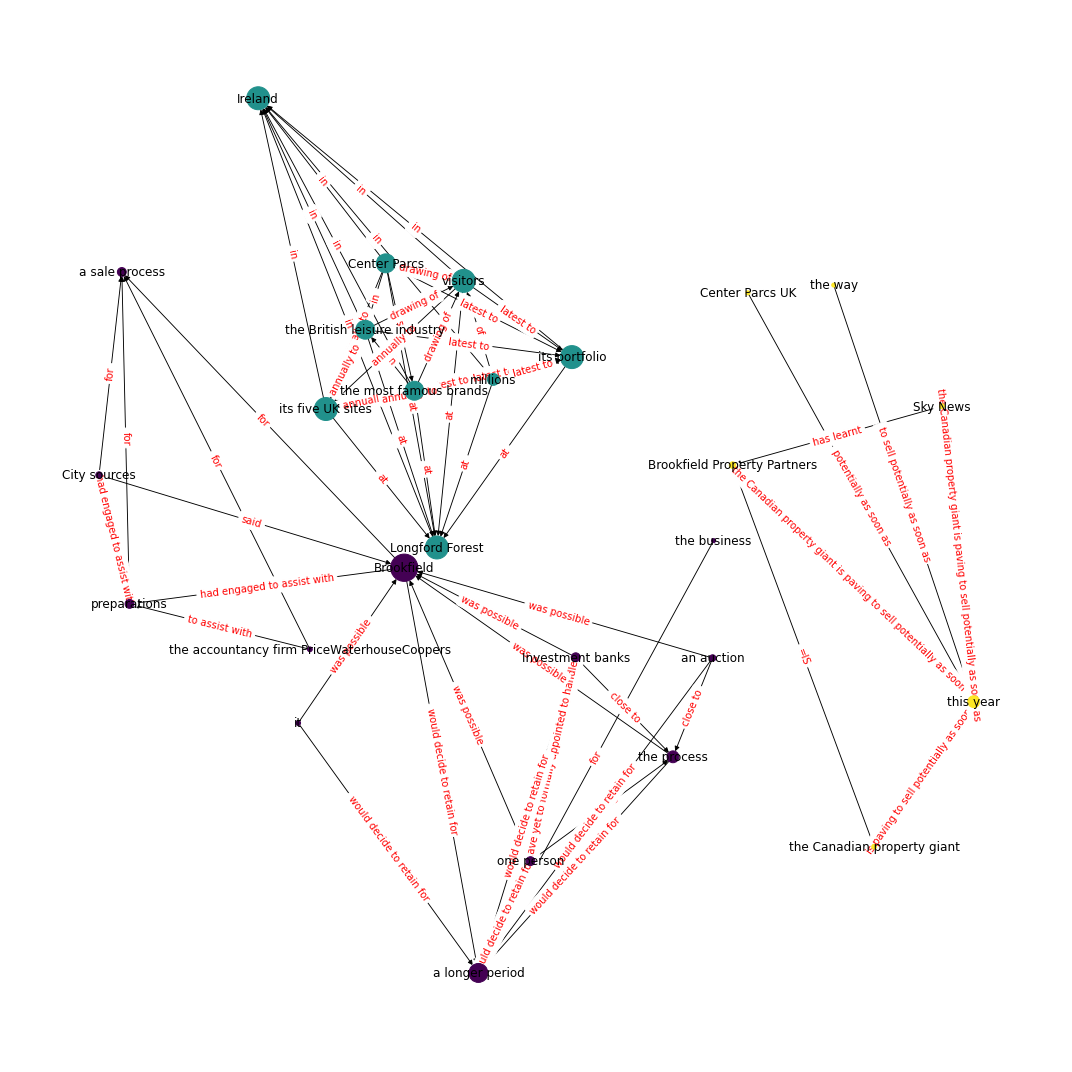

In [17]:
# plot graph
fig,axs = plt.subplots(1,1, figsize=(15,15))
pg = PlotGraph()
pg.plot_graph(axs,G)
plt.tight_layout()

I have added a function to colour the node's within the tightly connected "modular" portions of the network. When plotting the entire graph this highlights some distinct connected components and subgraphs of the overall knowledge graph. I.e. there are some entities and nodes that are not connected to one another at all. 

This is not surprising given the nature of the input data. Now, some of the content and entities in this data are for "Sky News" and about the expansion of "Center Park's". I could go an retrieve some more text about these entities, process them for relations, and add them to the graph. Would that be helpful? Possibly. But it would also create and relations from the new texts and that might be on new topics such as covid booking numbers or the appointment of a new CEO. Anything. The point is, when constructing the knowledge graph it is important to consider what data you want to model otherwise you might end up with a web of spaghetti.

Below, I split the graphs by connected component and re-plot. Note that I converted the DirectedGraph to an un-directed Graph to calculate the components as I'm just interested in any relationship at this point. 

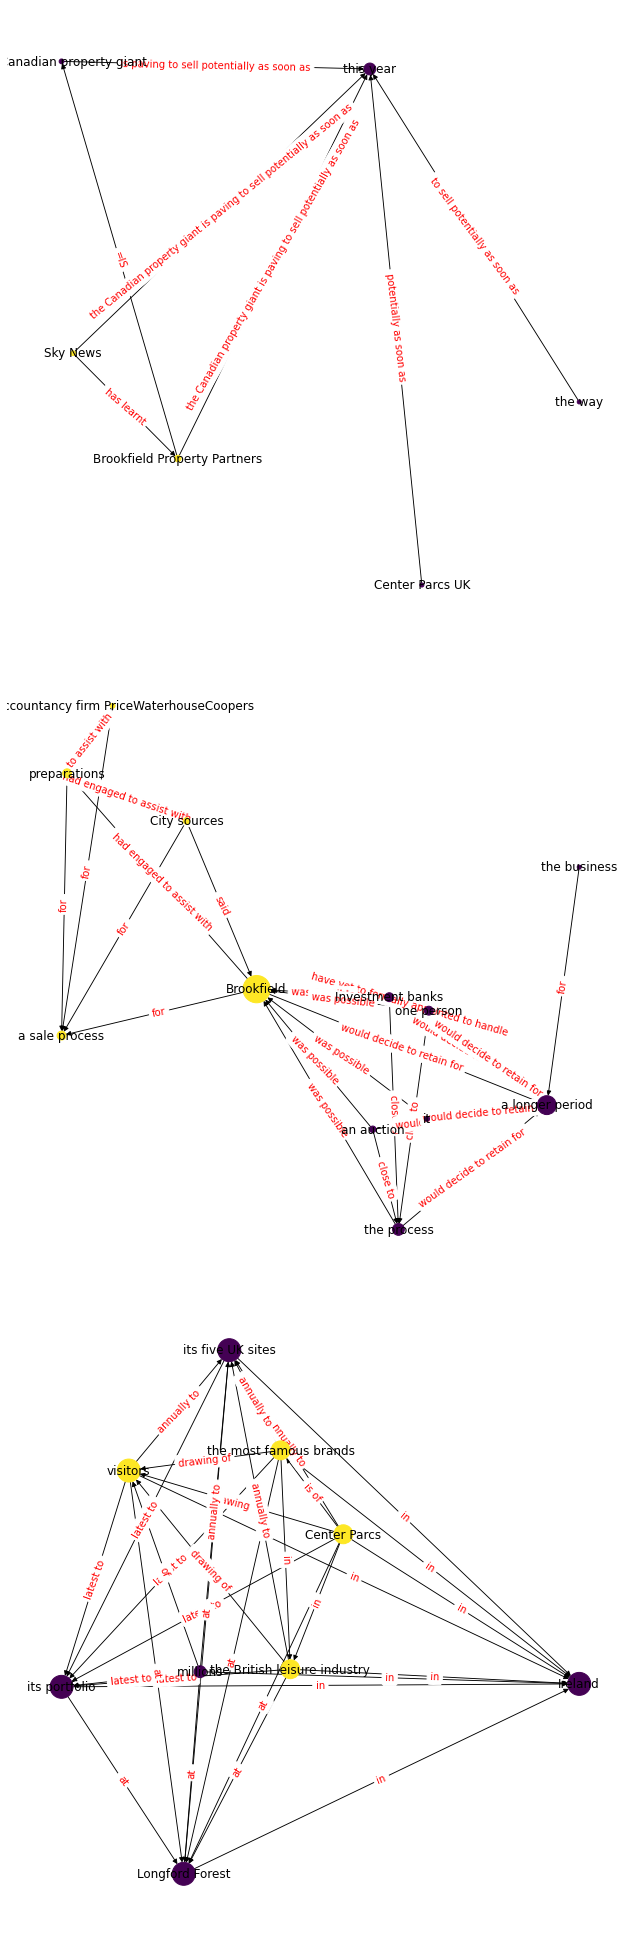

In [18]:
uG = G.to_undirected()
sg = [G.subgraph(c) for c in nx.connected_components(uG)]
ng = len(sg)

# plot graph
fig,axs = plt.subplots(ng,1, figsize=(9,ng*9))
pg = PlotGraph()
for ax,g in zip(axs.flatten(),sg):
    pg.plot_graph(ax,g)
    
plt.tight_layout()

#### [PyVis](https://pyvis.readthedocs.io/en/latest/index.html)

In [20]:
from pyvis.network import Network
net = Network(notebook=True,directed=True,height="700px",width="100%")
net.from_nx(sg[1])
net.show_buttons(filter_=['physics'])
net.show('graph.html')

#### Streamlit
Lastly, 

## Conclusion

- We could also consider [sentence simplification](https://stackoverflow.com/questions/65227103/clause-extraction-long-sentence-segmentation-in-python)

### Notes
spaCy uses the terms **head** and **child** to describe the words connected by a single arc in the dependency tree. The term **dep** is used for the arc label, which describes the type of syntactic relation that connects the child to the head.
 
```
 for token in doc:
    print(token,[token.head],list(token.children),end='\r')
```

## References
 - [information-extraction-with-dominating-rules](https://github.com/philipperemy/information-extraction-with-dominating-rules)
 - [Pruning Knowledge Graphs](http://philipperemy.github.io/information-extract/)
 - [OLLIE](https://www.reddit.com/r/LanguageTechnology/comments/bovsf5/we_release_opiec_the_largest_open_information/)
 - [Clausie](https://github.com/mmxgn/clausiepy)
 - [Minie](https://github.com/mmxgn/miniepy/graphs/contributors)
 - [Knowledge Graph – A Powerful Data Science Technique to Mine Information from Text](https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/)
 - [Spacy subject-object extraction](https://github.com/NSchrading/intro-spacy-nlp/blob/master/subject_object_extraction.py)
     -  [SO dependency parsing](https://stackoverflow.com/questions/39763091/how-to-extract-subjects-in-a-sentence-and-their-respective-dependent-phrases)
 - [sentence simplification](https://stackoverflow.com/questions/65227103/clause-extraction-long-sentence-segmentation-in-python)